In [2]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
np.random.seed(SEED)
tf.random.set_seed(SEED)  

In [2]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-ms4v6t3j
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-ms4v6t3j
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 7.7MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33791 sha256=59c51c469a969bcecd68ad23049b6cef2a92e8b355ecf17a5f09590222b905dd
  Stored in directory: /tmp/pip-ephem-wheel-cache-xczzwta4/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [1]:
import segmentation_models as sm


Segmentation Models: using `keras` framework.


In [3]:
from os import listdir, makedirs
from os.path import isfile, join, basename, splitext
from random import seed, shuffle
sm.set_framework('tf.keras')
cwd = os.getcwd()
cwd

'/content'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%%capture
!unzip /content/drive/My\ Drive/Dataset.zip


In [5]:
%%capture
!unzip /content/drive/My\ Drive/file.zip

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# in case add rescale factor rescale= 1./255,
""" 
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
"""
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')
else:
    img_data_gen = ImageDataGenerator()
    mask_data_gen = ImageDataGenerator()

In [8]:
def read_rgb_mask(img_path):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

In [9]:
from PIL import Image



class CustomDataset(tf.keras.utils.Sequence):

 

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'valid.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images/', curr_filename + '.png'))
    mask = Image.fromarray(read_rgb_mask(os.path.join(self.dataset_dir, 'Masks/', curr_filename + '.png')))

    # Resize image and mask
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img)
    mask_arr = np.array(mask)



    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [10]:
from os import listdir, makedirs
from os.path import isfile, join, basename, splitext
from random import seed, shuffle

def split_dataset(training_dir, split_dir, training_percentage=0.90):
    """
    Starting from a training directory, creates a split directory
    with two text files, enumerating the images present in the 
    training and the validation set. 
    """

    seed(1234)

    file_names = [f for f in listdir(training_dir) if isfile(join(training_dir, f))]
    shuffle(file_names)

    split = int(len(file_names)*training_percentage)
    train_file_names = "\n".join([splitext(basename(f))[0] for f in file_names[:split]])
    valid_file_names = "\n".join([splitext(basename(f))[0] for f in file_names[split:]])

    makedirs(split_dir)
    with open(join(split_dir, './train.txt'), 'w') as train:
        train.write(train_file_names)
    with open(join(split_dir, './valid.txt'), 'w') as valid:
        valid.write(valid_file_names)



dataset_dir = os.path.join("/content/Development_Dataset/Training/Roseau/Haricot")
split_dataset(join(dataset_dir, 'Images'), join(dataset_dir, 'Splits'))

In [11]:
from tensorflow.keras.applications.vgg16 import preprocess_input 
import os
img_h = 256
img_w = 256

num_classes = 3
dataset_dir = "/content/Development_Dataset/Training/Roseau/Haricot"


# Set preprocess_input = None to display original image
dataset = CustomDataset(dataset_dir, 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=preprocess_input)
dataset_valid = CustomDataset(dataset_dir, 'validation', 
                              preprocessing_function=preprocess_input)


In [12]:
bs = 8 # batch size try 3

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

In [13]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, num_classes)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0.]


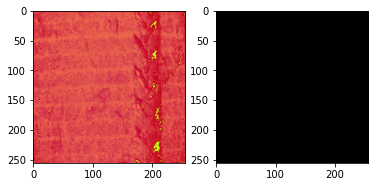

In [14]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, num_classes + 1):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

In [15]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)

In [ ]:
model = sm.Unet("efficientnetb5", classes=3, activation='softmax')

# Visualize created model as a table
model.summary()

## Prepare the model for training

In [20]:
# Optimization params

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1, num_classes): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
metrics = ['accuracy', meanIoU]
# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training with callbacks

In [21]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/Keras4/', 'b5_unet')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'b5_unet'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
    callbacks.append(es_callback)




# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

In [22]:
model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks)

Epoch 1/100
81/81 [==============================] - 126s 2s/step - loss: 0.9065 - accuracy: 0.6282 - meanIoU: 0.1098 - val_loss: 0.7095 - val_accuracy: 0.7824 - val_meanIoU: 0.1109
Epoch 2/100
81/81 [==============================] - 123s 2s/step - loss: 0.5907 - accuracy: 0.8563 - meanIoU: 0.2017 - val_loss: 0.5335 - val_accuracy: 0.8759 - val_meanIoU: 0.1670
Epoch 3/100
81/81 [==============================] - 121s 1s/step - loss: 0.4126 - accuracy: 0.9164 - meanIoU: 0.2864 - val_loss: 0.4195 - val_accuracy: 0.9204 - val_meanIoU: 0.2050
Epoch 4/100
81/81 [==============================] - 122s 2s/step - loss: 0.3102 - accuracy: 0.9318 - meanIoU: 0.3426 - val_loss: 0.3293 - val_accuracy: 0.9279 - val_meanIoU: 0.1954
Epoch 5/100
81/81 [==============================] - 122s 2s/step - loss: 0.2491 - accuracy: 0.9383 - meanIoU: 0.3933 - val_loss: 0.2730 - val_accuracy: 0.9295 - val_meanIoU: 0.1887
Epoch 6/100
81/81 [==============================] - 121s 1s/step - loss: 0.2093 - accurac

## Test model

## Compute prediction

In [27]:
model.save('/content/drive/MyDrive/model_roseau_b5_unet.h5')

In [ ]:
model = tf.keras.models.load_model('model_roseau_unet.h5', {'meanIoU': meanIoU})

In [28]:
iterator = iter(valid_dataset)

<class 'tensorflow.python.framework.ops.EagerTensor'>


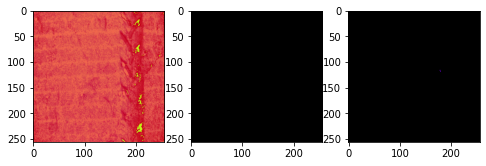

In [29]:
# Show original, correct, predicted (validation)

fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)
print(type(image))
image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...] #256*256
predicted_class.shape

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, num_classes):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, num_classes):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()

In [30]:
# Compute predictions

from os import listdir
from os.path import isfile, join, basename, splitext

# CustomTestDataset to load test images
# Specify the full path to the folder containing the images
class CustomTestDataset(tf.keras.utils.Sequence):

    def __init__(self, dataset_dir, img_generator=None, 
              preprocessing_function=None, out_shape=[img_h, img_w]):

      subset_filenames = [splitext(basename(f))[0] for f in 
                                                listdir(dataset_dir) if isfile(join(dataset_dir, f))]

      self.dataset_dir = dataset_dir
      self.subset_filenames = subset_filenames
      self.img_generator = img_generator
      self.preprocessing_function = preprocessing_function
      self.out_shape = out_shape


    def __len__(self):
        return len(self.subset_filenames)


    def get_original_size(self, index):
        curr_filename = self.subset_filenames[index]
        img = Image.open(os.path.join(self.dataset_dir, curr_filename + '.png'))
        width, height = img.size

        return [height, width]


    def __getitem__(self, index):
        # Read Image
        curr_filename = self.subset_filenames[index]
        img = Image.open(os.path.join(self.dataset_dir, curr_filename + '.png'))

        # Resize image and mask
        img = img.resize(self.out_shape)
        img_arr = np.array(img)

        if self.preprocessing_function is not None:
            img_arr = self.preprocessing_function(img_arr)

        return img_arr


    def get_name(self, index):
        return self.subset_filenames[index]

In [31]:
import json
from prepare_submission import rle_encode
test_dir = '/content/Development_Dataset/Test_Dev/Roseau/Haricot/Images'


test_dataset = CustomTestDataset(test_dir, preprocessing_function=preprocess_input)

submission_dict = {}

for i in range(test_dataset.__len__()):
    image = test_dataset.__getitem__(i)
    img_name = test_dataset.get_name(i)
    original_h, original_w = test_dataset.get_original_size(i)

    prediction = model.predict(tf.expand_dims(image, axis=0))
    mask_arr = tf.argmax(prediction, -1)[0, ...] # (256, 256)
    mask_arr = tf.expand_dims(mask_arr, axis=2)
    print(mask_arr.shape)
    mask_arr = tf.image.resize(mask_arr, (original_h, original_w),                          
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    mask_arr = np.array(mask_arr)

    submission_dict[img_name] = {}
    submission_dict[img_name]['shape'] = [original_h, original_w]
    submission_dict[img_name]['team'] = 'Roseau'
    submission_dict[img_name]['crop'] = 'Haricot'
    submission_dict[img_name]['segmentation'] = {}

    rle_encoded_crop = rle_encode(mask_arr == 1)
    rle_encoded_weed = rle_encode(mask_arr == 2)

    submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
    submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)


In [32]:

# empty submission for other datasets
def empty_submission(team, crop, dir):
    images_dir = join(dir, team, crop, 'Images')
    images_name = [splitext(basename(f))[0] for f in listdir(images_dir) if isfile(join(images_dir, f))]
    
    res = {}
    for img_name in images_name:
        res[img_name] = {}
        res[img_name]['shape'] = [256, 256] # non importa molto la shape per le submission vuote
        res[img_name]['team'] = team
        res[img_name]['crop'] = crop
        res[img_name]['segmentation'] = {}
        res[img_name]['segmentation']['crop'] = ""
        res[img_name]['segmentation']['weed'] = ""

    return res

dir = r'/content/Development_Dataset/Test_Dev'
submission_dict.update(empty_submission('Bipbip', 'Haricot', dir))
submission_dict.update(empty_submission('Bipbip', 'Mais', dir))
submission_dict.update(empty_submission('Pead', 'Haricot', dir))
submission_dict.update(empty_submission('Pead', 'Mais', dir))
submission_dict.update(empty_submission('Roseau', 'Mais', dir))
submission_dict.update(empty_submission('Weedelec', 'Haricot', dir))
submission_dict.update(empty_submission('Weedelec', 'Mais', dir))

with open('./submission.json', 'w') as f:
    json.dump(submission_dict, f)

In [33]:

# Show original, predicted (test)

test_dataset = CustomTestDataset(test_dir, preprocessing_function=preprocess_input)
test_iter = iter(test_dataset)

[0 1 2]


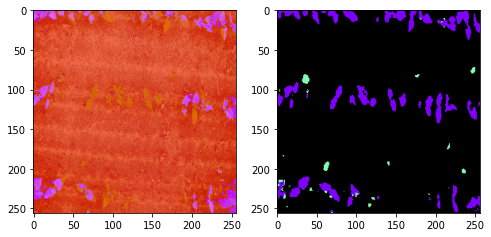

In [34]:
# Show original, predicted (test)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
fig.show()

image = next(test_iter)

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

predicted_class = tf.argmax(out_sigmoid, -1)[0, ...]
print(np.unique(np.array(predicted_class)))

# Assign colors (just for visualization)
prediction_img = np.zeros([image.shape[0], image.shape[1], 3])

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, num_classes+1):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(prediction_img))

fig.canvas.draw()